# **CUHK-STAT3009** Notebook -  Real dataset: MovieLens and Data virtualization


## Load all developed methods
- `glb_mean`
- `user_mean`
- `item_mean`
- `MF` and `MF_CV`

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
from sklearn.model_selection import KFold
import itertools

def rmse(true, pred):
	return np.sqrt(np.mean((pred - true)**2))

class glb_mean(object):
	def __init__(self):
		self.glb_mean = 0
	
	def fit(self, train_rating):
		self.glb_mean = np.mean(train_rating)
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))
		pred = pred*self.glb_mean
		return pred

class user_mean(object):
	def __init__(self, n_user):
		self.n_user = n_user
		self.glb_mean = 0.
		self.user_mean = np.zeros(n_user)
	
	def fit(self, train_pair, train_rating):
		self.glb_mean = train_rating.mean()
		for u in range(self.n_user):
			ind_train = np.where(train_pair[:,0] == u)[0]
			if len(ind_train) == 0:
				self.user_mean[u] = self.glb_mean
			else:
				self.user_mean[u] = train_rating[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.user_mean[user_tmp]
			j = j + 1
		return pred

class item_mean(object):
	def __init__(self, n_item):
		self.n_item = n_item
		self.glb_mean = 0.
		self.item_mean = np.zeros(n_item)
	
	def fit(self, train_pair, train_rating):
		self.glb_mean = train_rating.mean()
		for i in range(self.n_item):
			ind_train = np.where(train_pair[:,1] == i)[0]
			if len(ind_train) == 0:
				self.item_mean[i] = self.glb_mean
			else:
				self.item_mean[i] = train_rating[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.item_mean[item_tmp]
			j = j + 1
		return pred

class MF(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=50, tol=1e-4, verbose=1):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.tol = tol
        self.verbose = verbose

    def fit(self, train_pair, train_rating):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
        
        if self.verbose:
            print('Fitting Reg-MF: K: %d, lam: %.5f' %(K, lam))
        
        for i in range(iterNum):
            ## item update
            obj_old = self.obj(test_pair=train_pair, test_rating=train_rating)
            for item_id in range(n_item):
                index_item_tmp = self.index_item[item_id]
                if len(index_item_tmp) == 0:
                    self.Q[item_id,:] = 0.
                    continue
                ## compute `sum_pu` and `sum_matrix`
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_item_tmp:
                    ## double-check
                    if item_id != train_pair[record_ind][1]:
                        raise ValueError('the item_id is worning in updating Q!')
                    user_id, rating_tmp = train_pair[record_ind][0], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.P[user_id,:], self.P[user_id,:])
                    sum_pu = sum_pu + rating_tmp * self.P[user_id,:]                    
                self.Q[item_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_pu)
            
            for user_id in range(n_user):
                index_user_tmp = self.index_user[user_id]
                if len(index_user_tmp) == 0:
                    self.P[user_id,:] = 0.
                    continue
                ## compute `sum_qi` and `sum_matrix`
                sum_qi, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_user_tmp:
                    ## double-check
                    if user_id != train_pair[record_ind][0]:
                        raise ValueError('the user_id is worning in updating P!')
                    item_id, rating_tmp = train_pair[record_ind][1], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.Q[item_id,:], self.Q[item_id,:])
                    sum_qi = sum_qi + rating_tmp * self.Q[item_id,:]                    
                self.P[user_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_qi)
            # compute the new rmse score
            obj_new = self.obj(test_pair=train_pair, test_rating=train_rating)
            diff = abs(obj_new - obj_old) / obj_old
            if self.verbose:
                print("Reg-MF: ite: %d; diff: %.3f Obj: %.3f" %(i, diff, obj_new))
            if(diff < tol):
                break

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)
    
    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `MF`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )
      
    def obj(self, test_pair, test_rating):
        return (self.rmse(test_pair, test_rating))**2 + self.lam*np.sum(self.P**2) + self.lam*np.sum(self.Q**2)

class MF_CV(object):

	def __init__(self, n_user, n_item, cv=5,
				lams=[.000001,.0001,.001,.01], 
				Ks=[3,5,10,20], 
				iterNum=10, tol=1e-4):
		# self.index_item = []
		# self.index_user = []
		self.n_user = n_user
		self.n_item = n_item
		self.cv = cv
		self.lams = lams
		self.Ks = Ks
		self.iterNum = iterNum
		self.tol = tol
		self.best_model = {}
		self.cv_result = {'K': [], 'lam': [], 'train_rmse': [], 'valid_rmse': []}

	def grid_search(self, train_pair, train_rating):
		## generate all comb of `K` and `lam`
		kf = KFold(n_splits=self.cv, shuffle=True)
		for (K,lam) in itertools.product(self.Ks, self.lams):
			train_rmse_tmp, valid_rmse_tmp = 0., 0.
			for train_index, valid_index in kf.split(train_pair):
				# produce training/validation sets
				train_pair_cv, train_rating_cv = train_pair[train_index], train_rating[train_index]
				valid_pair_cv, valid_rating_cv = train_pair[valid_index], train_rating[valid_index]
				# fit the model based on CV data
				model_tmp = MF(self.n_user, self.n_item, K=K, lam=lam, verbose=0)
				model_tmp.fit(train_pair=train_pair_cv, train_rating=train_rating_cv)
				train_rmse_tmp_cv = model_tmp.rmse(test_pair=train_pair_cv, test_rating=train_rating_cv)
				valid_rmse_tmp_cv = model_tmp.rmse(test_pair=valid_pair_cv, test_rating=valid_rating_cv)
				train_rmse_tmp = train_rmse_tmp + train_rmse_tmp_cv / self.cv
				valid_rmse_tmp = valid_rmse_tmp + valid_rmse_tmp_cv / self.cv
				print('%d-Fold CV for K: %d; lam: %.5f: train_rmse: %.3f, valid_rmse: %.3f' 
						%(self.cv, K, lam, train_rmse_tmp_cv, valid_rmse_tmp_cv))
			self.cv_result['K'].append(K)
			self.cv_result['lam'].append(lam)
			self.cv_result['train_rmse'].append(train_rmse_tmp)
			self.cv_result['valid_rmse'].append(valid_rmse_tmp)
		self.cv_result = pd.DataFrame.from_dict(self.cv_result)
		best_ind = self.cv_result['valid_rmse'].argmin()
		self.best_model = self.cv_result.loc[best_ind]
	
	def plot_grid(self, data_source='valid'):
		sns.set_theme()
		if data_source == 'train':
			cv_pivot = self.cv_result.pivot("K", "lam", "train_rmse")
		elif data_source == 'valid':
			cv_pivot = self.cv_result.pivot("K", "lam", "valid_rmse")
		else:
			raise ValueError('data_source must be train or valid!')
		sns.heatmap(cv_pivot, annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
		plt.show()


## Load ML-100K raw data
- `README` from MovieLens (https://grouplens.org/datasets/movielens/100k/)
- Data types for real dataset usually differ from the standard type in the lecture
- check the `user_id` and `item_id`: mapping item_id to a continuous sequence based on `sklean.preprocessing`
- use `sklearn.model_selection.train_test_split` to generate train and test dataset
- create `train_pair`, `train_rating`, `test_pair`

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip

--2022-10-26 01:30:04--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  16.9MB/s    in 0.3s    

2022-10-26 01:30:06 (16.9 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



In [ ]:
!unzip ml-100k.zip -d ./

Archive:  ml-100k.zip
replace ./ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


- For illustration, we focus on `u1.base` and `u1.test`

In [ ]:
train = pd.read_csv('./ml-100k/u1.base', 
                 delimiter='\t', 
                 names=['user_id','item_id','rating','timestamp'], 
                 header=None)

In [ ]:
test = pd.read_csv('./ml-100k/u1.test', 
                 delimiter='\t', 
                 names=['user_id','item_id','rating','timestamp'], 
                 header=None)

In [ ]:
print('Total number of users: %d' %len(set(train['user_id'].append(test['user_id']))))
print('Max Id of users: %d' %max(set(train['user_id'].append(test['user_id']))))

Total number of users: 943
Max Id of users: 943


In [ ]:
print('Total number of items: %d' %len(set(train['item_id'].append(test['item_id']))))
print('Max Id of items: %d' %max(set(train['item_id'].append(test['item_id']))))

Total number of items: 1682
Max Id of items: 1682


## Exploratory data analysis (EDA)

### Rating-only

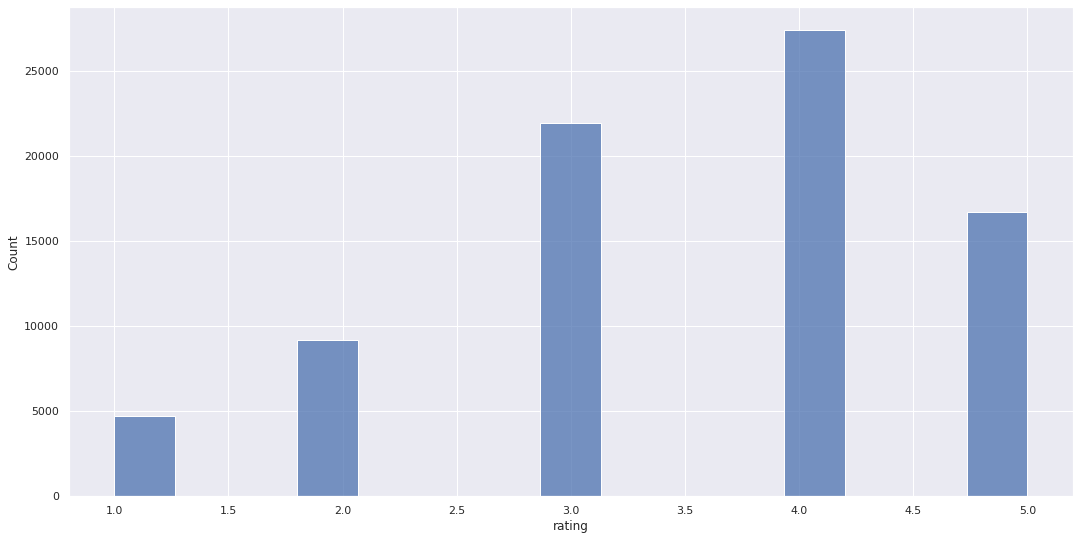

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 9)

sns.set_theme()
## histograms of rating 
sns.histplot(data=train, x="rating", bins=15)
plt.show()

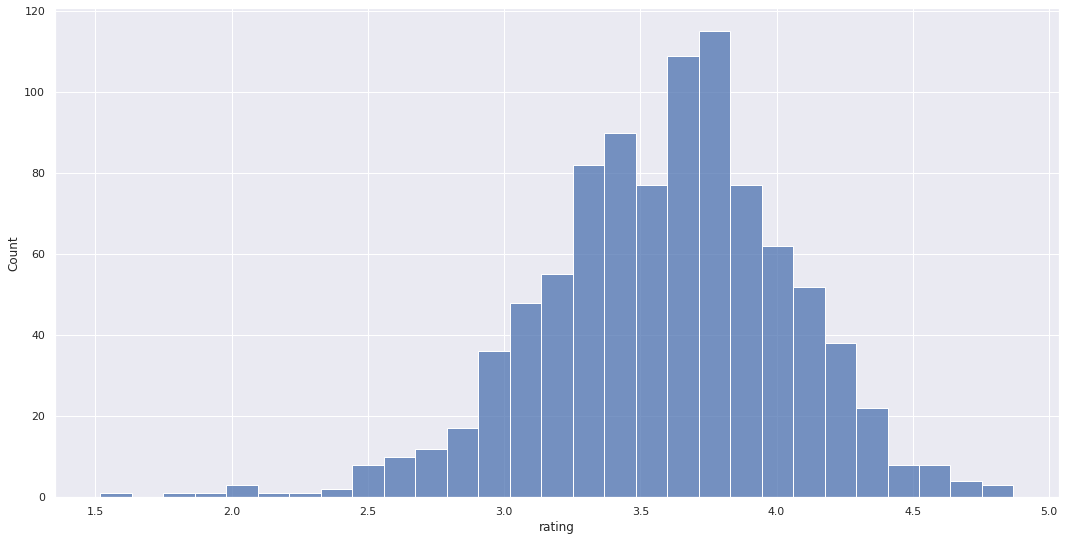

In [ ]:
sns.histplot(train.groupby('user_id')['rating'].mean())
plt.show()

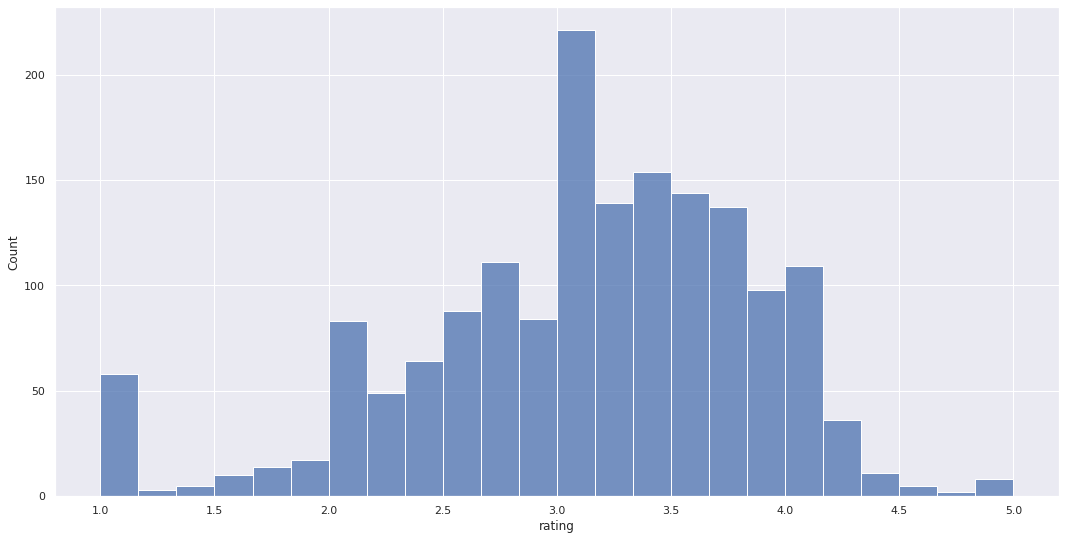

In [ ]:
sns.histplot(train.groupby('item_id')['rating'].mean())
plt.show()

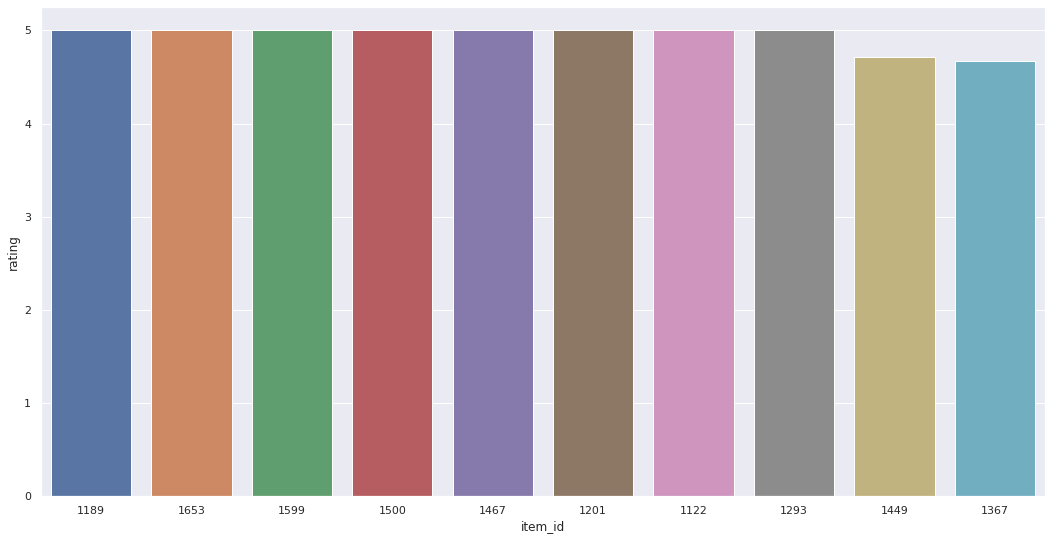

In [ ]:
## Find Top-10 highest rating movies 
di_hot = train.groupby('item_id')['rating'].mean().sort_values(ascending = False)[:10]
sns.barplot(x=di_hot.index, y=di_hot, order=di_hot.index)
plt.show()

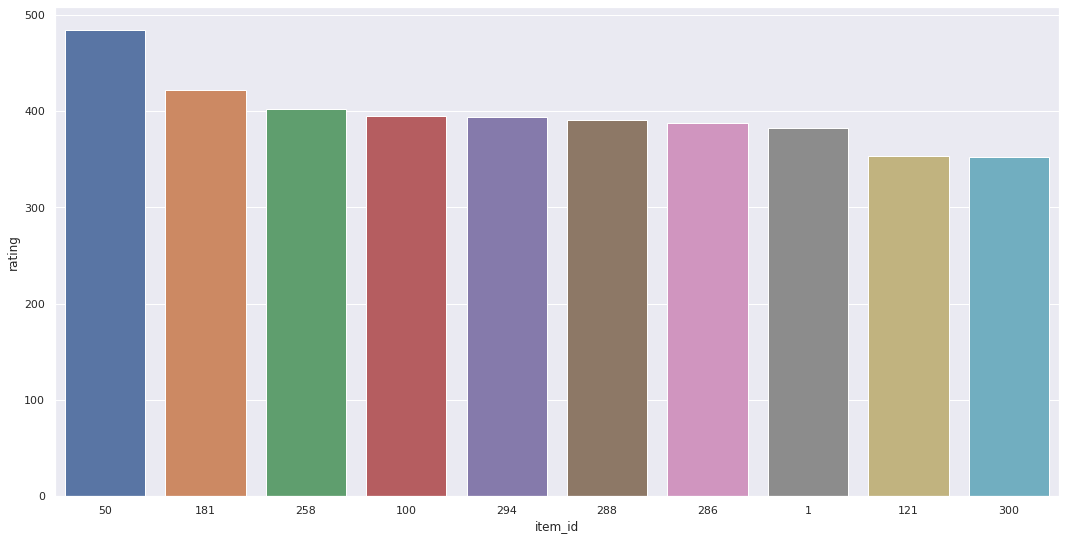

In [ ]:
## Find Top-10 most popular movies 
du_pop = train.groupby('item_id')['rating'].count().sort_values(ascending = False)[:10]
sns.barplot(x=du_pop.index, y=du_pop, order=du_pop.index)
plt.show()

In [ ]:
n_user = len(set(train['user_id']).intersection(set(test['user_id'])))
du = {'user_id': [], 'count': [], 'mean': []}
for u in range(n_user):
    rating_tmp = train[train['user_id']==u]
    if len(rating_tmp) > 0:
        du['user_id'].append(u)
        du['count'].append(len(rating_tmp))
        du['mean'].append(np.mean(rating_tmp['rating']))
du = pd.DataFrame(du)

In [ ]:
n_item = len(set(train['item_id']).intersection(set(test['item_id'])))

di = {'item_id': [], 'count': [], 'mean': []}
for i in range(n_item):
    rating_tmp = train[train['item_id']==i]
    if len(rating_tmp) > 0:
        di['item_id'].append(i)
        di['count'].append(len(rating_tmp))
        di['mean'].append(np.mean(rating_tmp['rating']))
di = pd.DataFrame(di)

In [ ]:
di.sample(5)

,item_id,count,mean
233,234,218,3.761468
760,763,130,3.423077
275,276,235,3.651064
464,465,70,3.514286
248,249,103,3.223301


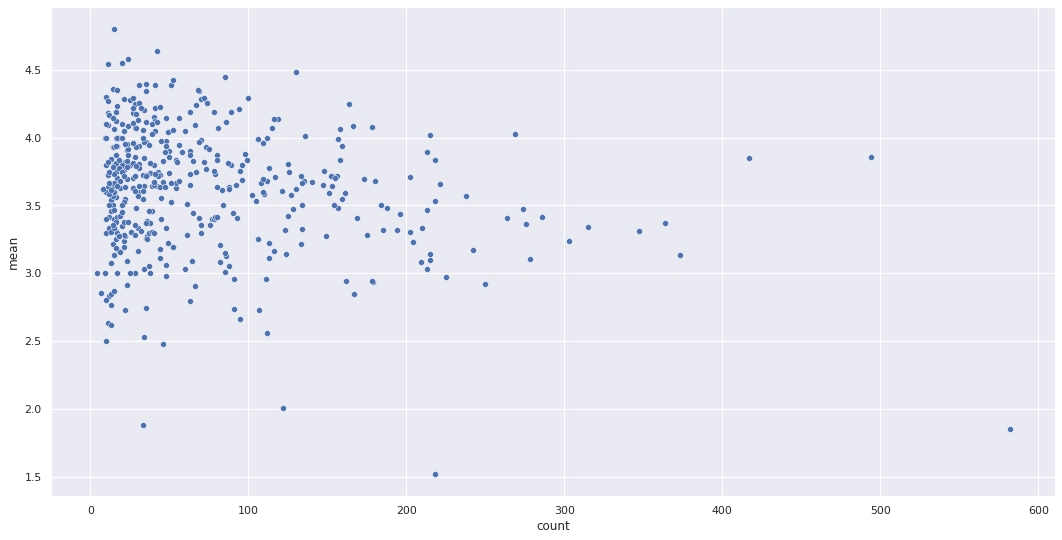

In [ ]:
sns.scatterplot(data=du, x="count", y="mean")
plt.show()

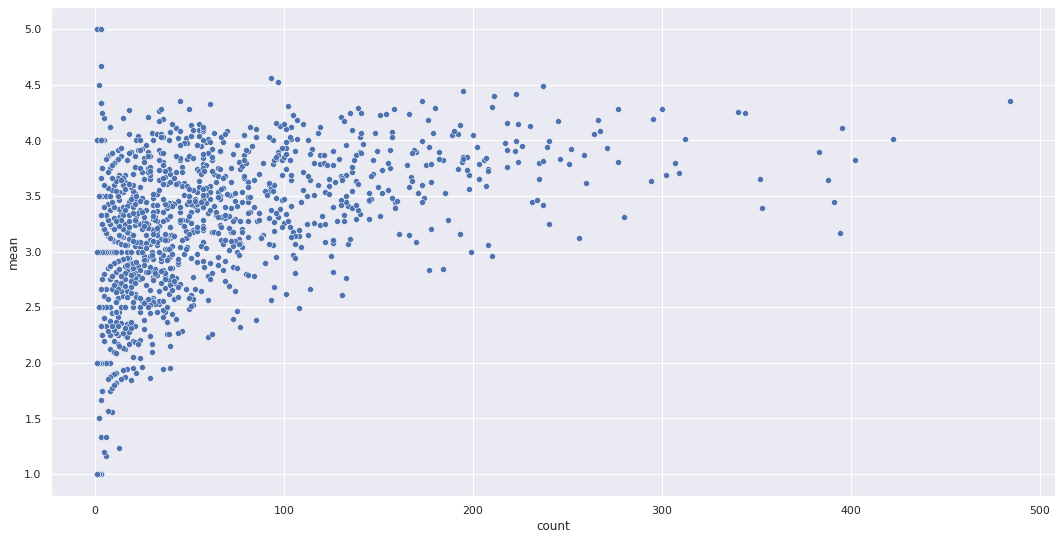

In [ ]:
sns.scatterplot(data=di, x="count", y="mean")
plt.show()

### Side information

### User side information EDA

In [ ]:
!cat ./ml-100k/u.user

1|24|M|technician|85711
2|53|F|other|94043
3|23|M|writer|32067
4|24|M|technician|43537
5|33|F|other|15213
6|42|M|executive|98101
7|57|M|administrator|91344
8|36|M|administrator|05201
9|29|M|student|01002
10|53|M|lawyer|90703
11|39|F|other|30329
12|28|F|other|06405
13|47|M|educator|29206
14|45|M|scientist|55106
15|49|F|educator|97301
16|21|M|entertainment|10309
17|30|M|programmer|06355
18|35|F|other|37212
19|40|M|librarian|02138
20|42|F|homemaker|95660
21|26|M|writer|30068
22|25|M|writer|40206
23|30|F|artist|48197
24|21|F|artist|94533
25|39|M|engineer|55107
26|49|M|engineer|21044
27|40|F|librarian|30030
28|32|M|writer|55369
29|41|M|programmer|94043
30|7|M|student|55436
31|24|M|artist|10003
32|28|F|student|78741
33|23|M|student|27510
34|38|F|administrator|42141
35|20|F|homemaker|42459
36|19|F|student|93117
37|23|M|student|55105
38|28|F|other|54467
39|41|M|entertainment|01040
40|38|M|scientist|27514
41|33|M|engineer|80525
42|30|M|administrator|17870
43|29|F|librarian|20854
44|26|M|technic

In [ ]:
n_cols = ['user_id', 'age', 'gender', 'occupation', 'zip code']
df_user = pd.read_csv('ml-100k/u.user', sep='|', names=n_cols , encoding='latin-1')

In [ ]:
df_user.sample(3).T

,574,262,251
user_id,575,263,252
age,33,41,42
gender,M,M,M
occupation,marketing,programmer,engineer
zip code,46032,55346,07733


In [ ]:
## Merge df
du_all = pd.merge(du, df_user, on='user_id', suffixes=("", ""))
du_all.sample(3).T

,413,119,375
user_id,414,120,376
count,22,14,22
mean,3.954545,3.571429,3.636364
age,24,47,28
gender,M,F,F
occupation,programmer,other,other
zip code,38115,06260,10010


In [ ]:
du_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458 entries, 0 to 457
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     458 non-null    int64  
 1   count       458 non-null    int64  
 2   mean        458 non-null    float64
 3   age         458 non-null    int64  
 4   gender      458 non-null    object 
 5   occupation  458 non-null    object 
 6   zip code    458 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 28.6+ KB


In [ ]:
du_all.nunique()

user_id       458
count         171
mean          354
age            56
gender          2
occupation     21
zip code      415
dtype: int64

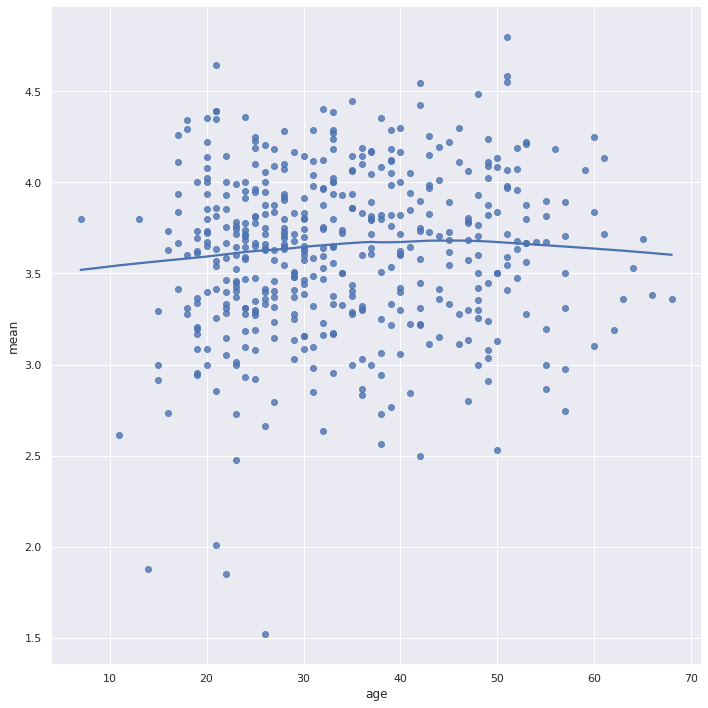

In [ ]:
sns.lmplot(data=du_all, x="age", y="mean", lowess=True, height=10)
plt.show()

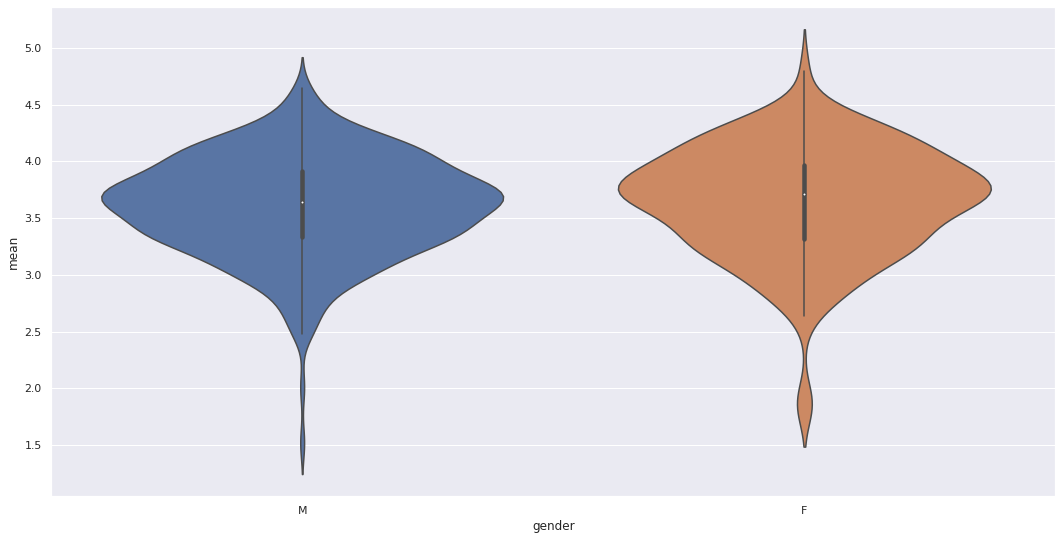

In [ ]:
sns.violinplot(data=du_all, x="gender", y="mean")
plt.show()

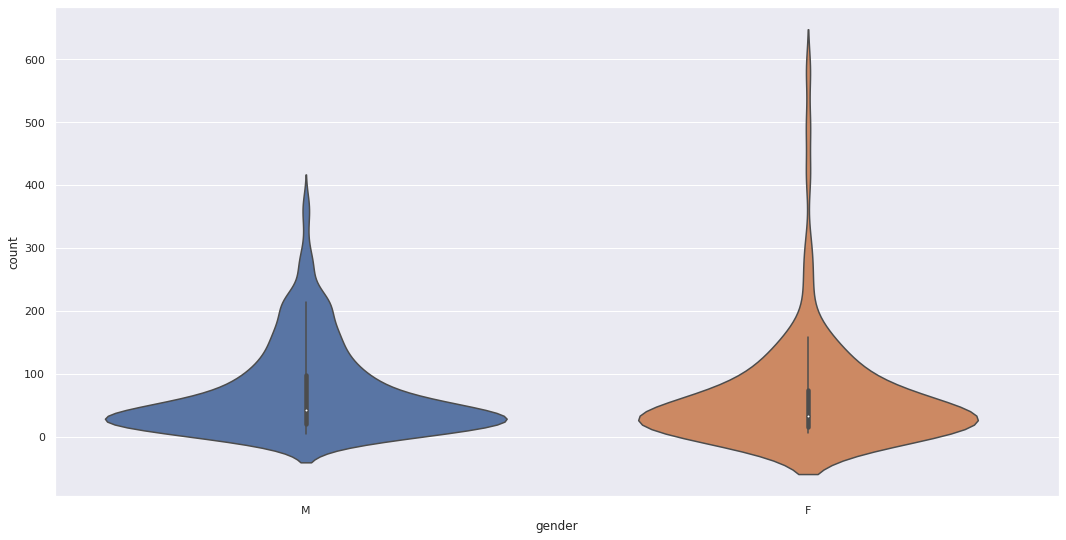

In [ ]:
sns.violinplot(data=du_all, x="gender", y="count")
plt.show()

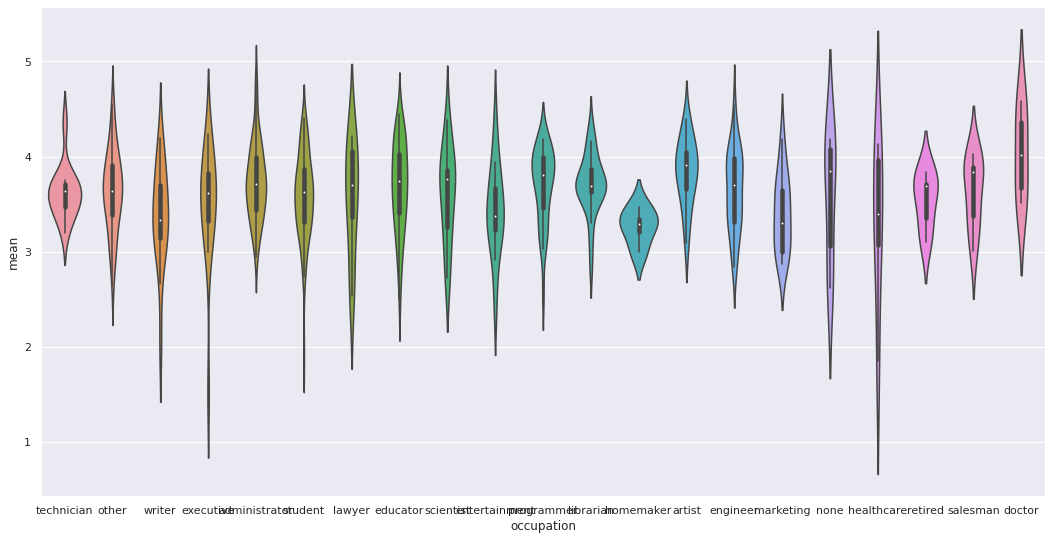

In [ ]:
sns.violinplot(data=du_all, x="occupation", y="mean")
plt.show()

In [ ]:
zipcode_lst = du_all.groupby('zip code')['mean'].count()
popZ = zipcode_lst.index[zipcode_lst > 2]
popZ

Index(['20009', '22903', '55105', '55108', '55414', '60201', '80525', '94043'], dtype='object', name='zip code')

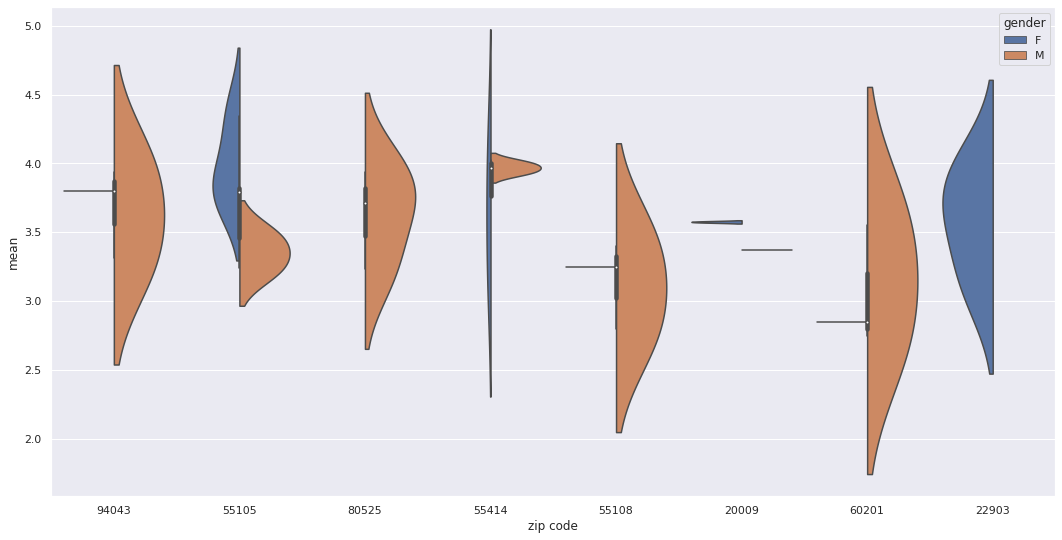

In [ ]:
sns.violinplot(data=du_all.iloc[np.isin(du_all['zip code'],popZ)], 
               x="zip code", y="mean", hue='gender', split=True)
plt.show()

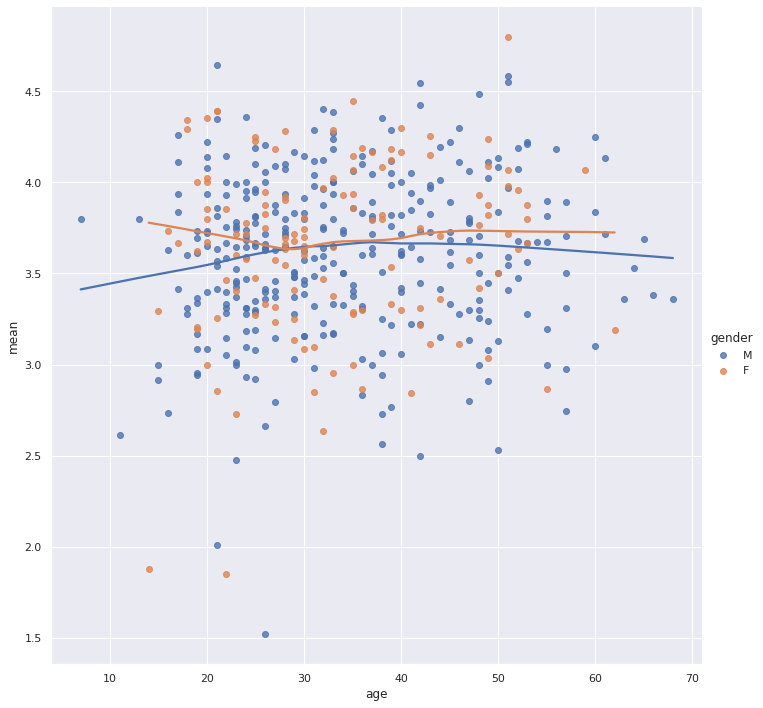

In [ ]:
sns.lmplot(data=du_all, x="age", y="mean", hue='gender', lowess=True, height=10)
plt.show()

### Item side information EDA

In [ ]:
m_cols = ['item_id','title','date','video_date', 'URL',
          'unknown', 'Action', 'Adventure', 'Animation',
          'Children', 'Comedy', 'Crime', 'Documentary',
          'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
          'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
          'Western']
df_item = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols , encoding='latin-1')

In [ ]:
df_item.sample(3).T

,903,431,322
item_id,904,432,323
title,Ma vie en rose (My Life in Pink) (1997),Fantasia (1940),Dante's Peak (1997)
date,26-Dec-1997,01-Jan-1940,07-Feb-1997
video_date,NaN,NaN,NaN
URL,http://us.imdb.com/M/title-exact?imdb-title-11...,http://us.imdb.com/M/title-exact?Fantasia%20(1...,http://us.imdb.com/M/title-exact?Dante's%20Pea...
unknown,0,0,0
Action,0,0,1
Adventure,0,0,0
Animation,0,1,0
Children,0,1,0


In [ ]:
di_all = pd.merge(di, df_item, on='item_id', suffixes=("", ""))
di_all.sample(3).T

,734,254,654
item_id,737,255,656
count,49,140,36
mean,3.040816,3.342857,4.027778
title,Sirens (1994),My Best Friend's Wedding (1997),M (1931)
date,01-Jan-1994,20-Jun-1997,01-Jan-1931
video_date,NaN,NaN,NaN
URL,http://us.imdb.com/M/title-exact?Sirens%20(1994),http://us.imdb.com/M/title-exact?My+Best+Frien...,http://us.imdb.com/M/title-exact?M%20(1931)
unknown,0,0,0
Action,0,0,0
Adventure,0,0,0


In [ ]:
## remove NaN
del di_all['video_date']
## remove URL, might be useful, but we do not use it in the STAT3009
del di_all['URL']

In [ ]:
## Generate year and month
di_all['year'] = pd.DatetimeIndex(di_all['date']).year
di_all['month'] = pd.DatetimeIndex(di_all['date']).month

In [ ]:
di_all.sample(3).T

,649,278,476
item_id,651,279,477
count,141,21,78
mean,4.06383,3.285714,3.179487
title,Glory (1989),Once Upon a Time... When We Were Colored (1995),Matilda (1996)
date,01-Jan-1989,01-Jan-1995,02-Aug-1996
unknown,0,0,0
Action,1,0,0
Adventure,0,0,0
Animation,0,0,0
Children,0,0,1


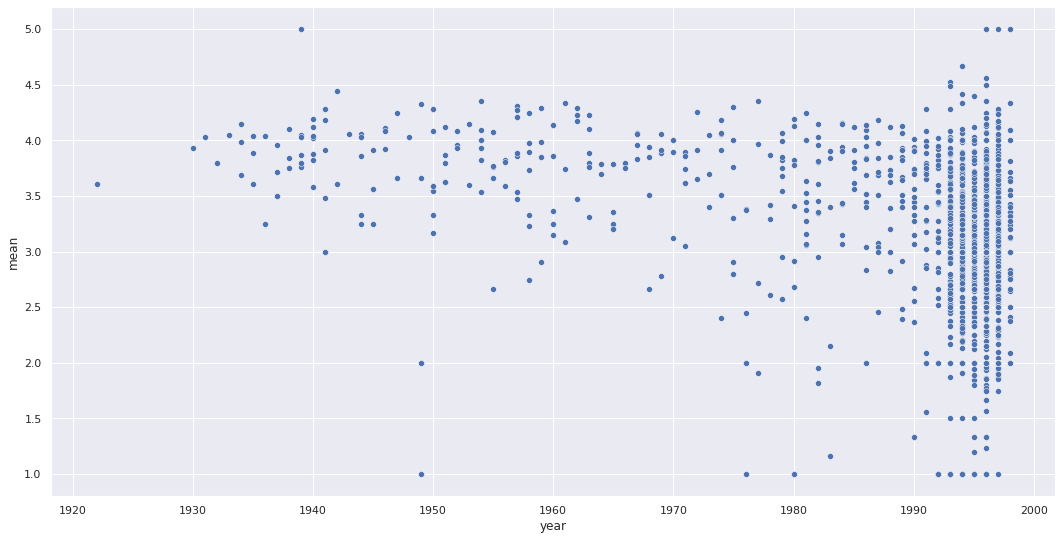

In [ ]:
sns.scatterplot(data=di_all, x="year", y="mean")
plt.show()

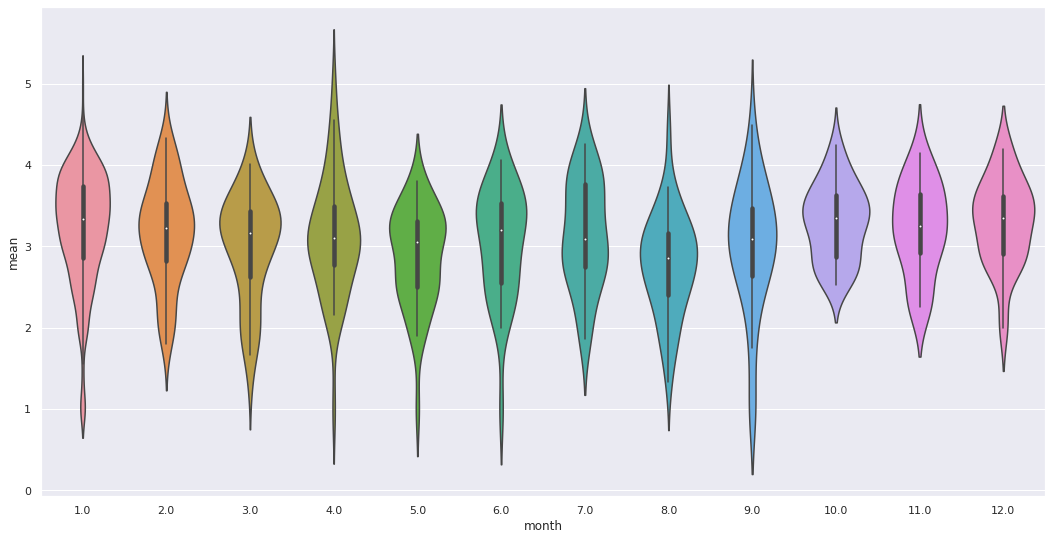

In [ ]:
sns.violinplot(data=di_all, x="month", y="mean")
plt.show()

In [ ]:
m_cols[5:]

['unknown',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [ ]:
di_all['gene'] = di_all[m_cols[5:]].idxmax(axis=1)
di_all.sample(3).T

,888,438,1198
item_id,895,439,1206
count,88,3,10
mean,3.136364,1.0,2.7
title,Scream 2 (1997),Amityville: A New Generation (1993),Amos & Andrew (1993)
date,01-Jan-1997,01-Jan-1993,01-Jan-1993
unknown,0,0,0
Action,0,0,0
Adventure,0,0,0
Animation,0,0,0
Children,0,0,0


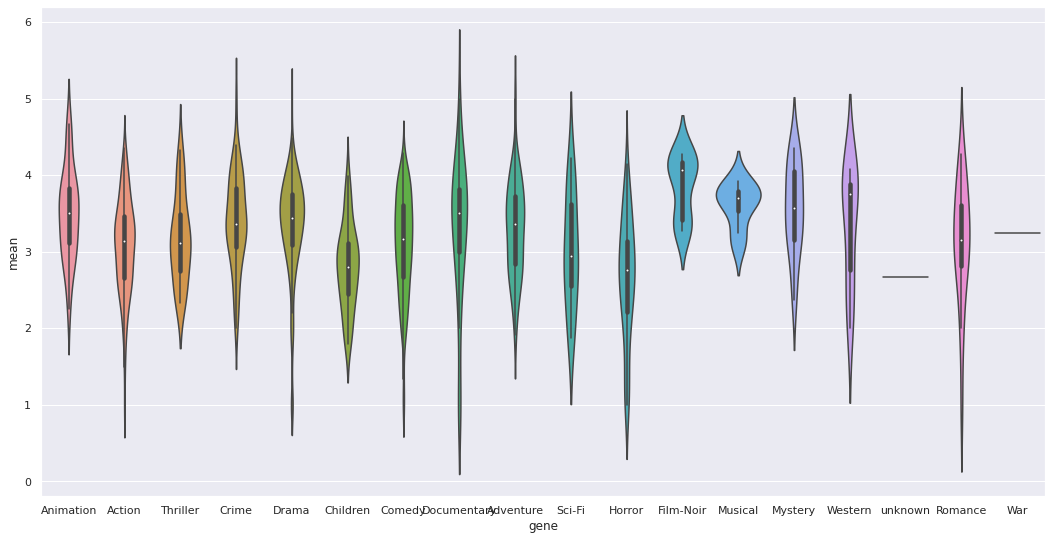

In [ ]:
plt.rcParams['figure.figsize'] = (18, 9)

sns.violinplot(data=di_all, x="gene", y="mean")
plt.show()

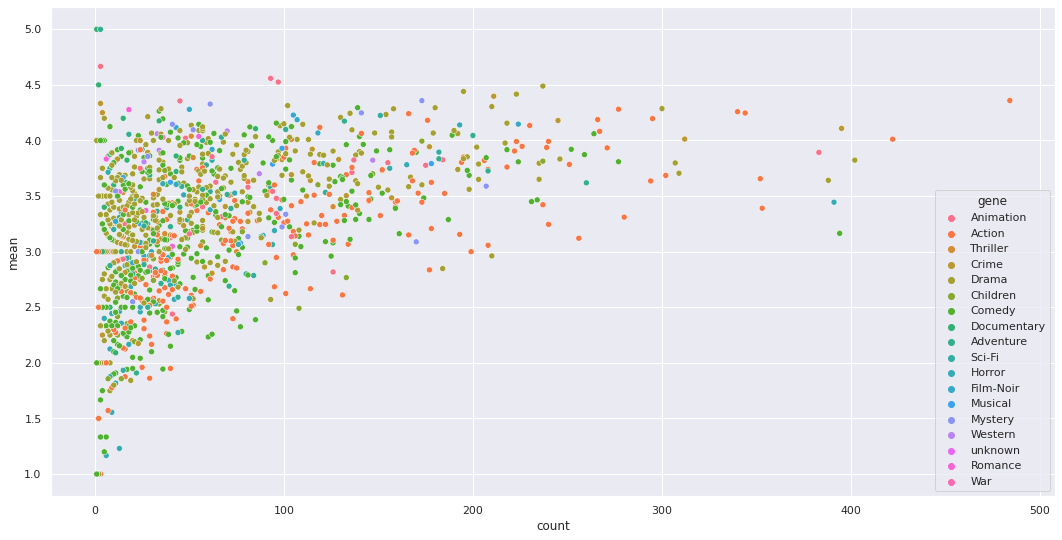

In [ ]:
sns.scatterplot(data=di_all, x="count", y="mean", hue='gene')
plt.show()

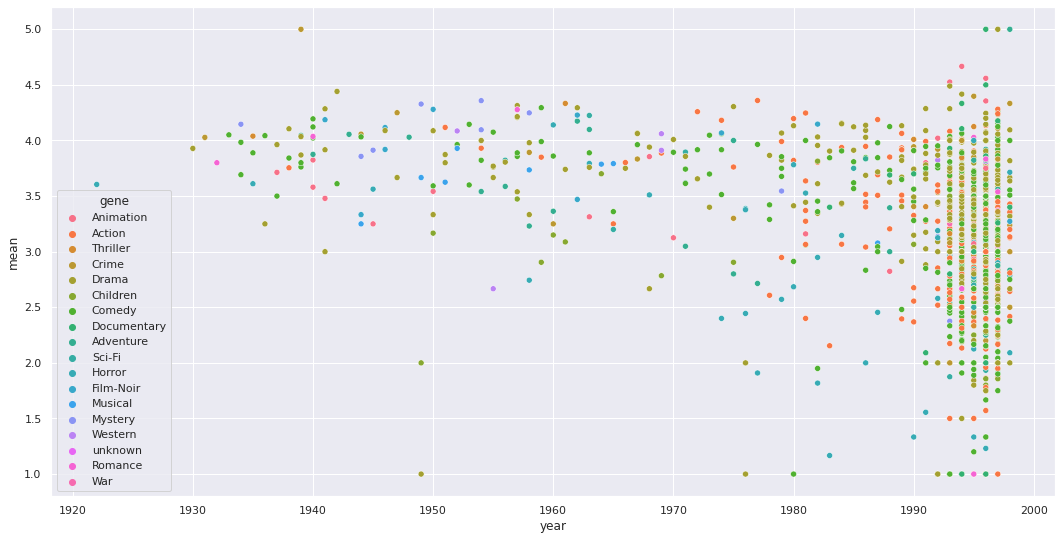

In [ ]:
sns.scatterplot(data=di_all, x="year", y="mean", hue='gene')
plt.show()

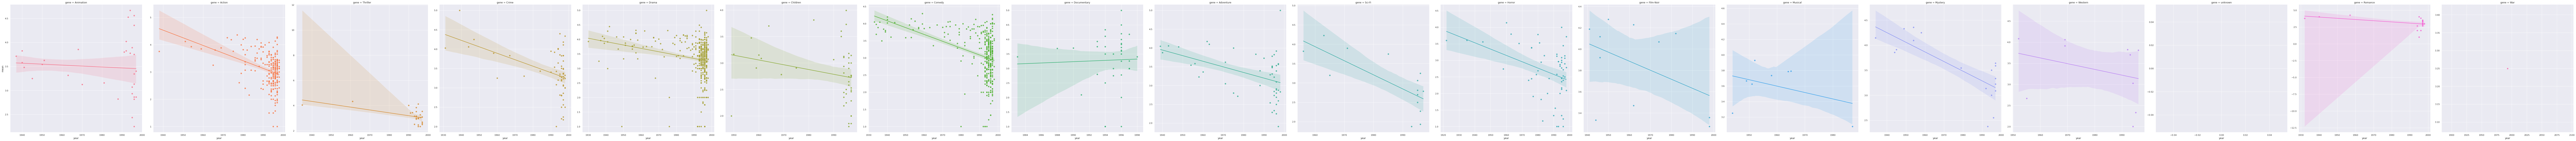

In [ ]:
sns.lmplot(
    data=di_all, x="year", y="mean",
    col="gene", height=10, hue="gene",
    facet_kws=dict(sharex=False, sharey=False),
)

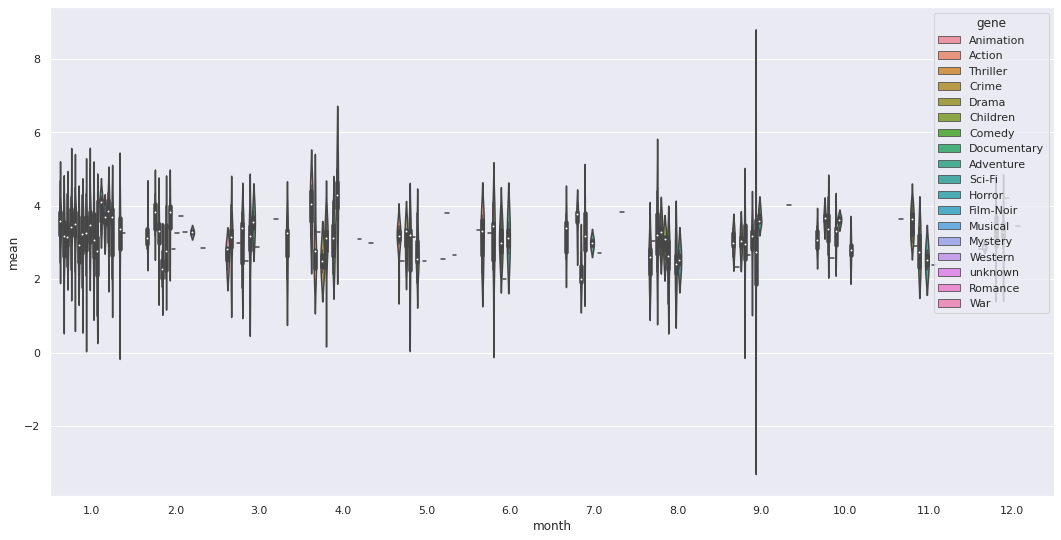

In [ ]:
sns.violinplot(data=di_all, x="month", y="mean", hue="gene")

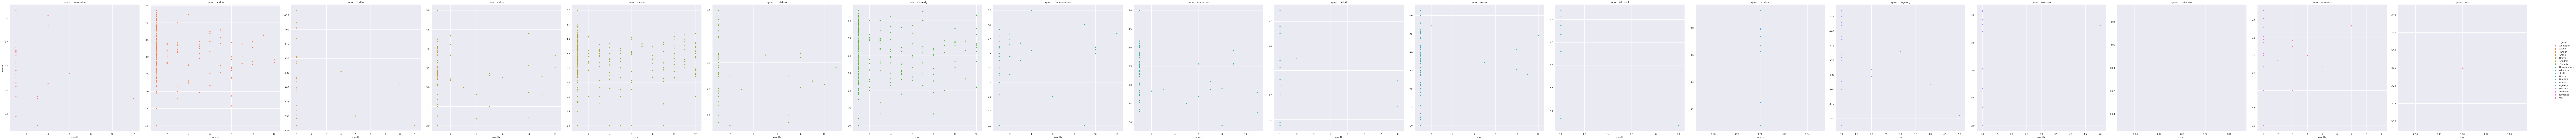

In [ ]:
sns.relplot(
    data=di_all, x="month", y="mean",
    col="gene", height=10, hue="gene", kind="scatter",
    facet_kws=dict(sharex=False, sharey=False),
)

## Conclusion

- Both **side informtion** for *users*/*items* are important
- The **joint effect** from features is significant to rating prediction

## **Personalization**: do we still need **MF** term?

In [ ]:
du_all.sort_values(by=['count'], ascending=False)

,user_id,count,mean,age,gender,occupation,zip code
404,405,582,1.848797,22,F,healthcare,10019
449,450,494,3.858300,35,F,educator,11758
415,416,417,3.851319,20,F,student,92626
12,13,373,3.136729,47,M,educator,29206
428,429,364,3.370879,27,M,student,29205
...,...,...,...,...,...,...,...
92,93,9,3.000000,48,M,executive,23112
35,36,9,4.000000,19,F,student,93117
257,258,8,3.625000,19,F,student,77801
227,228,7,2.857143,21,F,student,22003


We going to look at the records:

|user_id|count|mean|age|gender|occupation|zip code|
|--- |--- |	--- |	--- |	--- |	--- |---|
|450 |494|3.858300 | 35 | F |	educator |11758|
|330 |85 |4.447059 | 35 |	F |	educator |33884|


In [ ]:
dp = train[(train['user_id'] == 450) | (train['user_id'] == 330)]
dp

,user_id,item_id,rating,timestamp
19580,330,1,5,876544432
19581,330,15,5,876544366
19582,330,21,5,876544953
19583,330,25,5,876544582
19584,330,28,5,876546526
...,...,...,...,...
30783,450,1480,3,882468686
30784,450,1490,3,882396929
30785,450,1518,4,887138957
30786,450,1521,3,882812350


In [ ]:
dp = pd.merge(dp, di_all[['item_id', 'year', 'date', 'gene', 'month']], on='item_id')

In [ ]:
dp.sample(5)

,user_id,item_id,rating,timestamp,year,date,gene,month
526,450,1044,4,887139844,1994.0,01-Jan-1994,Comedy,1.0
344,450,469,4,882396153,1993.0,01-Jan-1993,Drama,1.0
555,450,1248,4,882399664,1994.0,01-Jan-1994,Thriller,1.0
494,450,823,3,887139729,1996.0,26-Apr-1996,Crime,4.0
240,450,208,5,882377358,1974.0,01-Jan-1974,Comedy,1.0


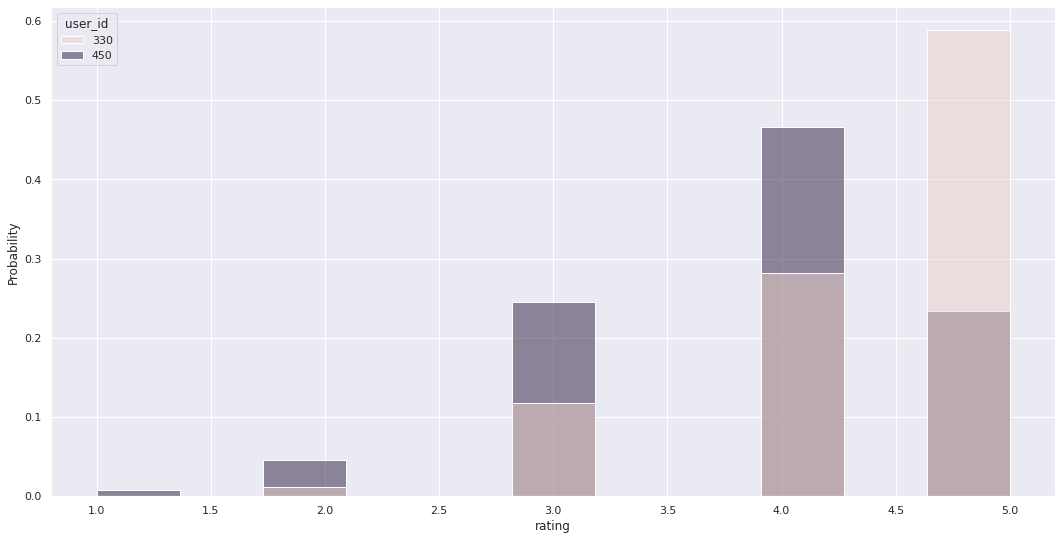

In [ ]:
sns.histplot(data=dp, x="rating", hue="user_id", stat='probability', common_norm=False)

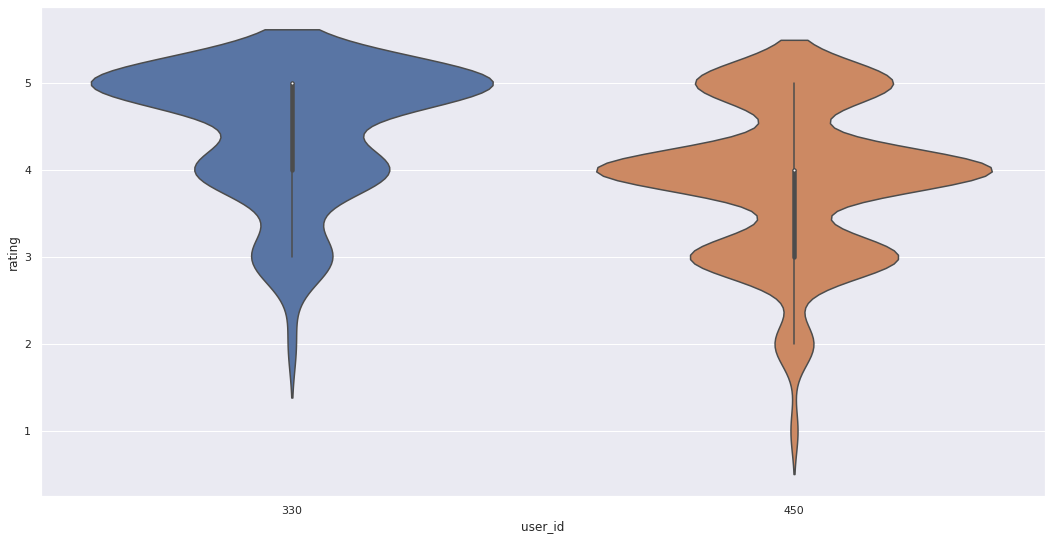

In [ ]:
sns.violinplot(data=dp, x="user_id", y="rating")

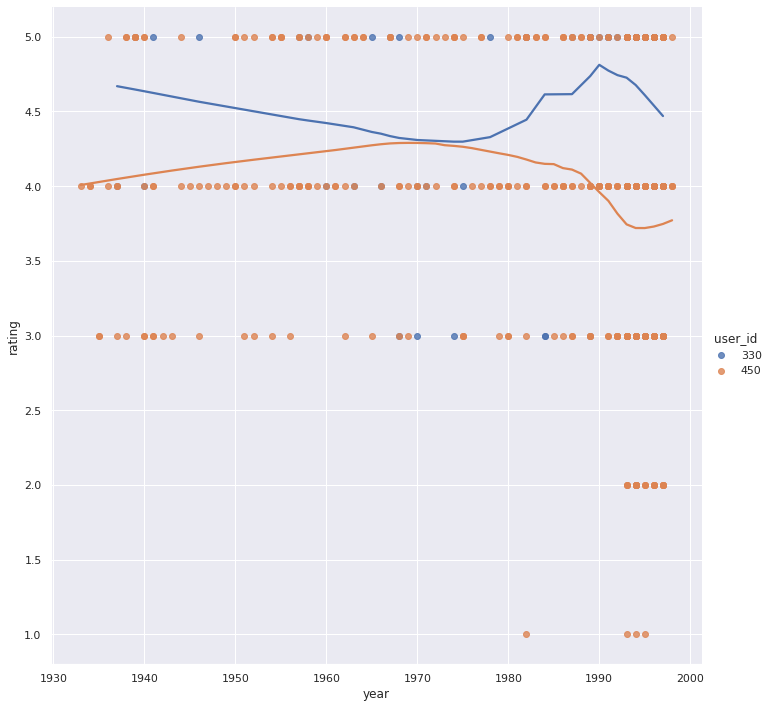

In [ ]:
sns.lmplot(data=dp, x="year", y="rating", hue='user_id', lowess=True, height=10)

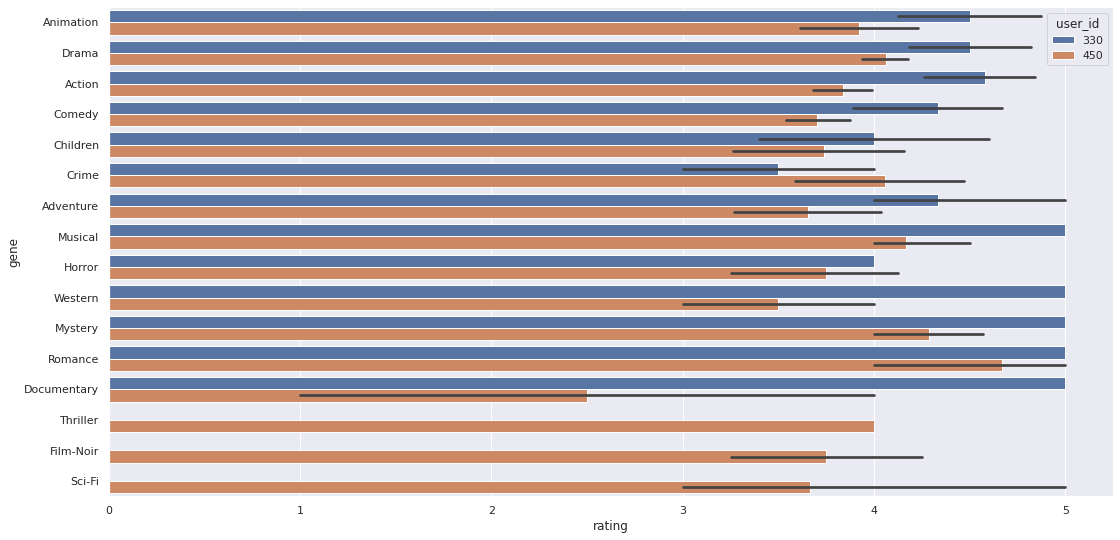

In [ ]:
sns.barplot(x="rating", y="gene", hue='user_id', data=dp)

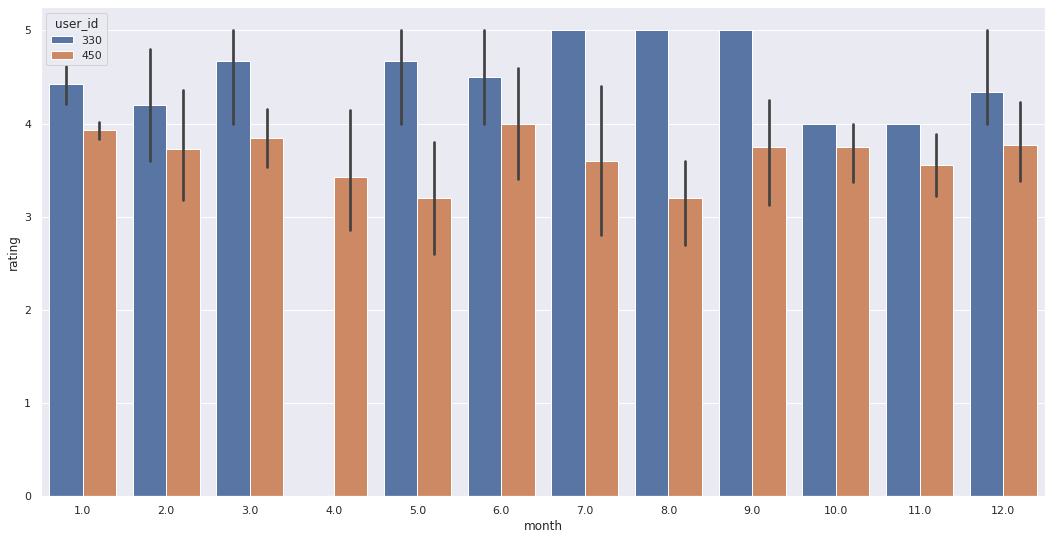

In [ ]:
sns.barplot(x="month", y="rating", hue='user_id', data=dp)

## Conclusion
- **Personalization** is still important
- **Joint effecct** from (`user_id`, `gene`), (`user_id`, `year`), ... should be taken into account in the model.

## Method

### Pre-processing

- The ML-100K use `user id` and `item id` starting from 1, we should redefine the IDs starting from 0
- The simplest way is to minus all IDs by 1, but more generally we use `sklearn.preprocessing.LabelEncoder`

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
## example
le.fit([1, 2, 2, 6])
le.transform([1,2,6])

array([0, 1, 2])

In [ ]:
## Label encoding for users/items
le_user = preprocessing.LabelEncoder()
le_user.fit(train['user_id'].append(test['user_id']))
le_item = preprocessing.LabelEncoder()
le_item.fit(train['item_id'].append(test['item_id']))

for df in [train, test]:
  df['user_id'] = le_user.transform(df['user_id'])
  df['item_id'] = le_item.transform(df['item_id'])

In [ ]:
print('Total number of users: %d' %len(set(train['user_id'].append(test['user_id']))))
print('Max Id of users: %d' %max(set(train['user_id'].append(test['user_id']))))

Total number of users: 943
Max Id of users: 942


In [ ]:
print('Total number of items: %d' %len(set(train['item_id'].append(test['item_id']))))
print('Max Id of items: %d' %max(set(train['item_id'].append(test['item_id']))))

Total number of items: 1682
Max Id of items: 1681


In [ ]:
del train['timestamp']
train.sample(5)

,user_id,item_id,rating
70300,851,288,2
59387,732,321,2
67429,824,242,4
613,6,648,5
1593,17,715,5


In [ ]:
del test['timestamp']
test.sample(5)

,user_id,item_id,rating
8701,193,1219,3
12713,275,549,4
587,7,300,4
15872,320,1027,2
7071,155,47,4


In [ ]:
## stadard data type
train_pair = train[['user_id', 'item_id']].values
train_rating = train['rating'].values

test_pair = test[['user_id', 'item_id']].values
test_rating = test['rating'].values
n_user, n_item = max(train_pair[:,0].max(), test_pair[:,0].max())+1, max(train_pair[:,1].max(), test_pair[:,1].max())+1

In [ ]:
## Baseline
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred_glb = glb_ave.predict(test_pair)
print('RSME for gbl mean: %.3f' %rmse(test_rating, pred_glb))

RSME for gbl mean: 1.154


In [ ]:
# user_mean
train_rating_cm = train_rating - glb_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_rating=train_rating_cm)
pred_user_mean = pred_glb + user_ave.predict(test_pair)
print('RSME for user-mean: %.3f' %rmse(test_rating, pred_user_mean))

RSME for user-mean: 1.063


In [ ]:
## item mean
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_rating=train_rating_cm)
pred_item_mean = pred_glb + item_ave.predict(test_pair)
print('RSME for item-mean: %.3f' %rmse(test_rating, pred_item_mean))

RSME for item-mean: 1.033


3-Fold CV for K: 2; lam: 0.00001: train_rmse: 0.845, valid_rmse: 0.945
3-Fold CV for K: 2; lam: 0.00001: train_rmse: 0.843, valid_rmse: 0.950
3-Fold CV for K: 2; lam: 0.00001: train_rmse: 0.844, valid_rmse: 0.950
3-Fold CV for K: 2; lam: 0.00002: train_rmse: 0.847, valid_rmse: 0.941
3-Fold CV for K: 2; lam: 0.00002: train_rmse: 0.849, valid_rmse: 0.935
3-Fold CV for K: 2; lam: 0.00002: train_rmse: 0.844, valid_rmse: 0.949
3-Fold CV for K: 2; lam: 0.00004: train_rmse: 0.850, valid_rmse: 0.941
3-Fold CV for K: 2; lam: 0.00004: train_rmse: 0.854, valid_rmse: 0.935
3-Fold CV for K: 2; lam: 0.00004: train_rmse: 0.856, valid_rmse: 0.929
3-Fold CV for K: 2; lam: 0.00008: train_rmse: 0.868, valid_rmse: 0.924
3-Fold CV for K: 2; lam: 0.00008: train_rmse: 0.865, valid_rmse: 0.932
3-Fold CV for K: 2; lam: 0.00008: train_rmse: 0.861, valid_rmse: 0.940
3-Fold CV for K: 2; lam: 0.00016: train_rmse: 0.890, valid_rmse: 0.930
3-Fold CV for K: 2; lam: 0.00016: train_rmse: 0.886, valid_rmse: 0.939
3-Fold

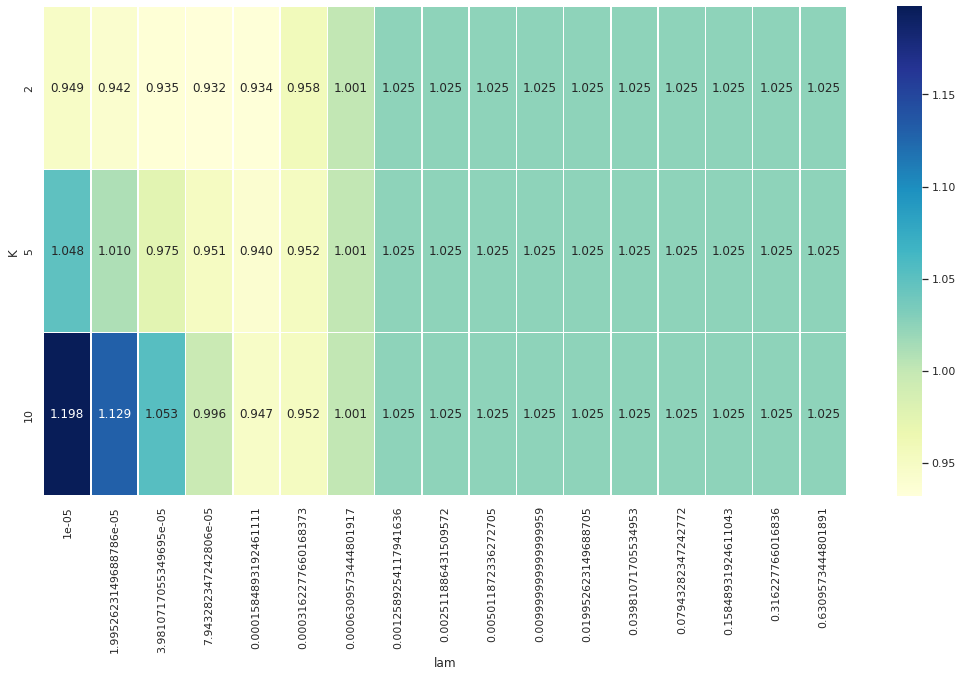

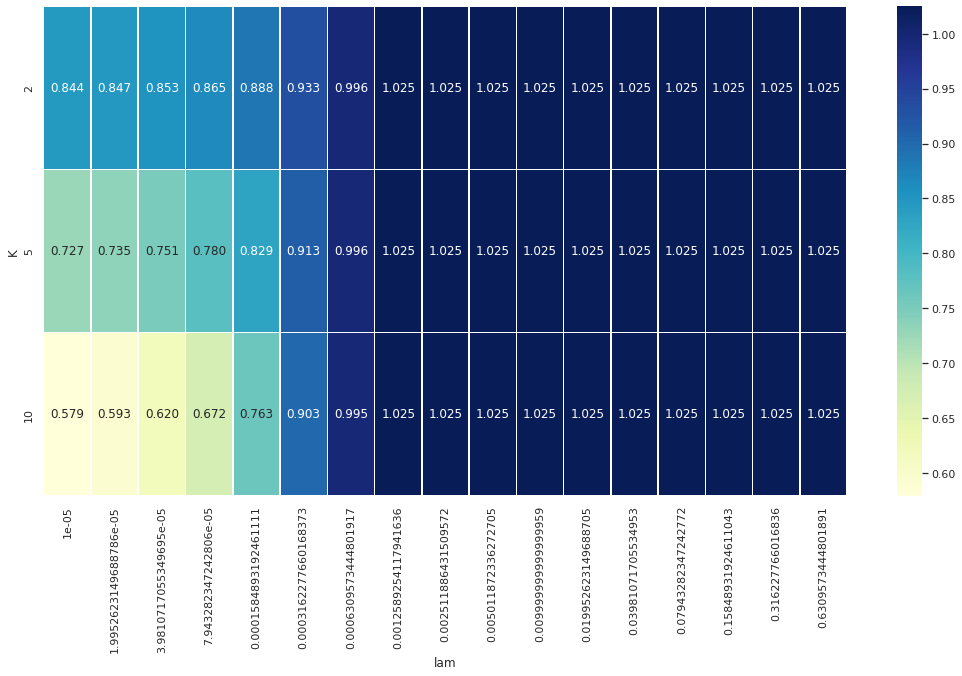

In [ ]:
# fit user_mean + MF_CV by residual ratings 
train_rating_res = train_rating_cm - user_ave.predict(train_pair)

Ks, lams = [2, 5, 10], 10**np.arange(-5, 0., .3)
ML_MF_cv = MF_CV(n_user, n_item, cv=3, Ks=Ks, lams=lams)
ML_MF_cv.grid_search(train_pair, train_rating_res)
ML_MF_cv.plot_grid('valid')
ML_MF_cv.plot_grid('train')

In [ ]:
print(ML_MF_cv.best_model)
best_K, best_lam = ML_MF_cv.best_model['K'], ML_MF_cv.best_model['lam']

K             2.000000
lam           0.000079
train_rmse    0.864738
valid_rmse    0.932019
Name: 3, dtype: float64


In [ ]:
best_MF = MF(n_user, n_item, K=int(best_K), lam=best_lam)
best_MF.fit(train_pair, train_rating_res)

Fitting Reg-MF: K: 2, lam: 0.00008
Reg-MF: ite: 0; diff: 0.700 Obj: 1.032
Reg-MF: ite: 1; diff: 0.135 Obj: 0.893
Reg-MF: ite: 2; diff: 0.030 Obj: 0.867
Reg-MF: ite: 3; diff: 0.011 Obj: 0.857
Reg-MF: ite: 4; diff: 0.005 Obj: 0.853
Reg-MF: ite: 5; diff: 0.003 Obj: 0.851
Reg-MF: ite: 6; diff: 0.001 Obj: 0.850
Reg-MF: ite: 7; diff: 0.000 Obj: 0.849
Reg-MF: ite: 8; diff: 0.000 Obj: 0.849
Reg-MF: ite: 9; diff: 0.000 Obj: 0.849


In [ ]:
pred_MF = pred_user_mean + best_MF.predict(test_pair)
print('RMSE for user_mean + MF: %.3f' %rmse(test_rating, pred_MF))

RMSE for user_mean + MF: 0.949


### Model dicsussion

- Incorproate **side information**
- Other than the joint effect from (`user_id`,`item_id`), we need to consider joint effects from (items' side info <-> users' side info), (`user_id` <-> items' side info) and (`item_id` <-> users' side info) 